## Matrix Cookbook
- https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf

In [18]:
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [19]:
x = np.matrix(np.arange(0.01, 1, 0.01)).T

In [20]:
y = np.log(x)

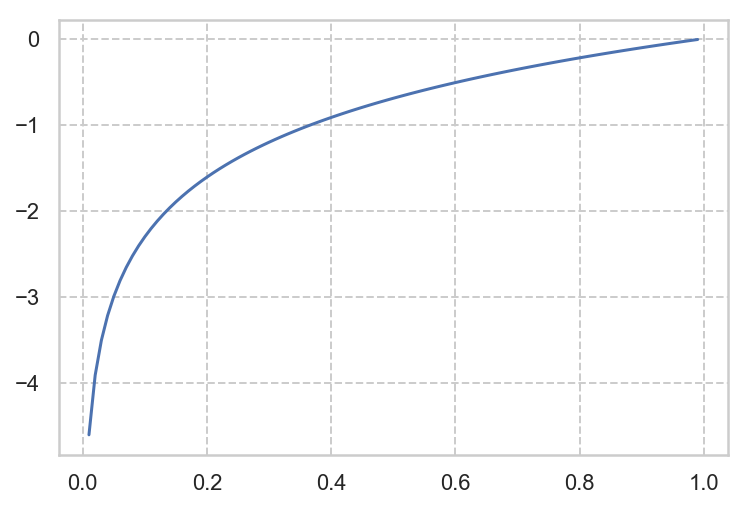

In [21]:
plt.plot(x.T.tolist()[0], y.T.tolist()[0])


In [22]:
data = np.loadtxt("gpr-cauchy.dat")

## 観測ノイズ実装
$$ k(x,x') = \theta_1 \exp{\left( -\frac{|x-x'|^2}{\theta_2} \right)} + \theta_3 \delta(x, x') $$

- $\delta(x, x')$ は、カーネル行列の対角成分である場合のみ1を返す
    - $x=x'$の時**ではない**ので注意

In [129]:
import math

def gaussian_kernel_2(x1, x2, params, diagonal):
    # diagnol ... 対角成分だったらTrue(デルタ関数の実装)
    # x1 == x2 とは関係ないので注意
    theta1 = params["theta1"]
    theta2 = params["theta2"]
    theta3 = params["theta3"]
    ret = theta1 * math.exp(-1 * ((x1-x2) ** 2 / theta2))
    if diagonal:
        ret += theta3
    return ret

In [64]:
def gpr2(xtest, xtrain, ytrain, kernel, params):
    N = len(ytrain)
    M = len(xtest)
    K = np.matrix(np.zeros((N, N)))
    
    for n1 in range(0, N):
        for n2 in range(0, N):
            K[n1, n2] = kernel(xtrain[n1], xtrain[n2], params, n1==n2)
            
    yy = K.I * ytrain
    
    k = np.matrix(np.zeros((N,1))).T
    
    mu = []
    var = []
    
    for m in range(0, M):
        for n in range(0, N):
            k[0,n] = (kernel(xtrain[n], xtest[m], params, False))
        s = kernel(xtest[m], xtest[m], params, True)
        mu.append(np.asscalar(k * yy))
        var.append(np.asscalar(s - k * K.I * k.T))
    return (np.array(mu), np.array(var))

In [82]:
x = np.matrix([1,3,4,6,8]).T
y = np.matrix([-1,2,3,-0.5,3]).T

In [83]:
x_test = np.matrix(np.arange(-10, 10, 0.1)).T

In [95]:
params={
    "theta1" : 1.0,
    "theta2" : 1.0,
    "theta3" : 0,
}

mu, var = gpr2(x_test, x, y, gaussian_kernel_2, params)

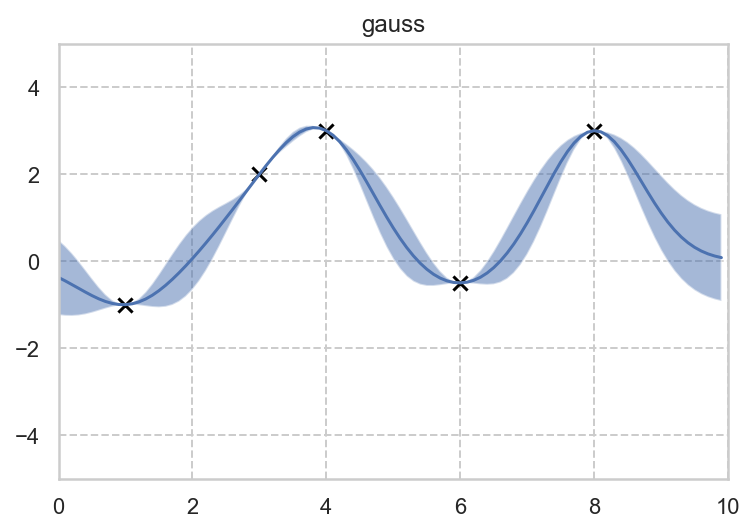

In [96]:
#グラフ化
plt.figure()
plt.xlim(0,10)
plt.ylim(-5,5)
plt.title('gauss')

#学習データ
plt.scatter(x.T.tolist()[0], y.T.tolist()[0], s=50, c='black',marker='x')

#予測値(期待値)
plt.plot(x_test.T.tolist()[0], mu)
plt.fill_between(x_test.T.tolist()[0], mu-var, mu+var, facecolor='b',alpha=0.5)

## ハイパラ推定
$$ \frac{\partial L}{\partial \theta} = -tr(\mathbf{K_\theta ^{-1}} \frac{\partial \mathbf{K}_\theta}{\partial \theta}) + (\mathbf{K}_\theta ^{-1}\mathbf{y})^T\frac{\partial \mathbf{K}_\theta}{\partial \theta}(\mathbf{K}_\theta ^{-1}\mathbf{y})  $$

ここで、

$$ \frac{\partial k(\mathbf{x_n}, \mathbf{x_{n^{'}}})}{\partial \tau} = k(\mathbf{x_n}, \mathbf{x_{n^{'}}}) -e^\eta \delta(n,n^{'}) $$
$$ \frac{\partial k(\mathbf{x_n}, \mathbf{x_{n^{'}}})}{\partial \sigma} = (k(\mathbf{x_n}, \mathbf{x_{n^{'}}}) -e^\eta \delta(n,n^{'})) \cdot e ^{-\sigma} |\mathbf{x}_n-\mathbf{x}_{n^{'}} | ^2$$
$$ \frac{\partial k(\mathbf{x_n}, \mathbf{x_{n^{'}}})}{\partial \eta} = e^\eta \delta(n,n^{'})$$ 

## コーシー分布
###


In [102]:
def cauchy(x, x0, gamma):
    return (math.pi*(gamma+(x-x0)**2/gamma))**-1

In [117]:
def gauss(x, mu, sigma2):
    return (math.pi*2*sigma2)**(-1/2)*math.exp(-1*(x-mu)**2/2*sigma2)

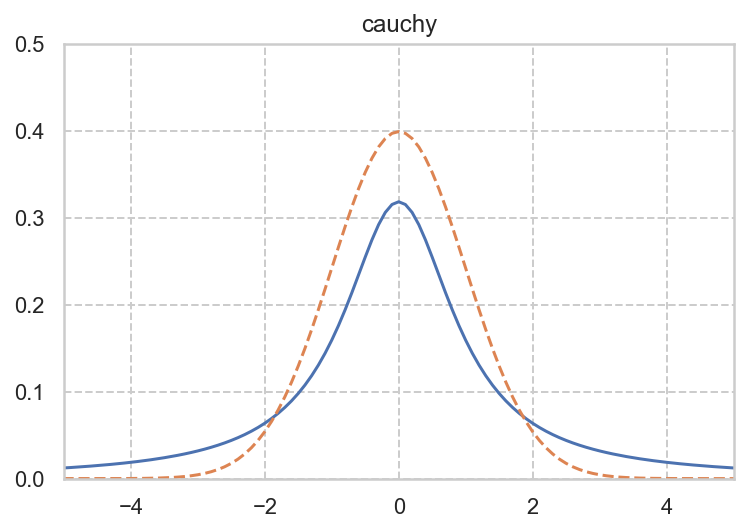

In [121]:
x_test = (np.arange(-10, 10, 0.1)).tolist()
y_c = [cauchy(x_t, 0, 1) for x_t in x_test]
y_g = [gauss(x_t, 0, 1) for x_t in x_test]


#グラフ化
plt.figure()
plt.xlim(-5,5)
plt.ylim(0,0.5)
plt.title('cauchy')

#学習データ
plt.plot(x_test, y_c)
plt.plot(x_test, y_g, "--")

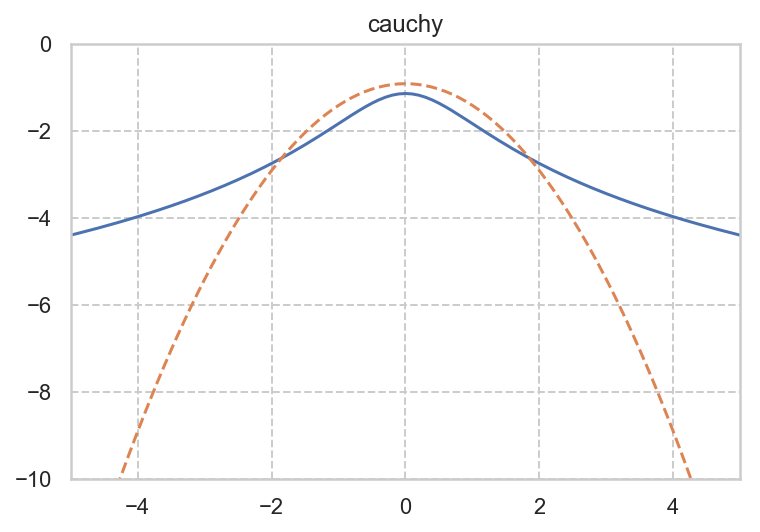

In [126]:
x_test = (np.arange(-10, 10, 0.1)).tolist()
logy_c = [math.log(cauchy(x_t, 0, 1)) for x_t in x_test]
logy_g = [math.log(gauss(x_t, 0, 1)) for x_t in x_test]


#グラフ化
plt.figure()
plt.xlim(-5,5)
plt.ylim(-10,0)
plt.title('cauchy')

#学習データ
plt.plot(x_test, logy_c)
plt.plot(x_test, logy_g, "--")

In [99]:
def gaussian_kernel_2(x1, x2, params, diagonal):
    # diagnol ... 対角成分だったらTrue(デルタ関数の実装)
    # x1 == x2 とは関係ないので注意
    tau = params["tau"]
    sigma = params["sigma"]
    rho = params["rho"]
    ret = math.e**tau * math.exp(-1 * ((x1-x2) ** 2 / math.e ** sigma))
    if diagonal:
        ret += math.e**rho
    return ret

In [97]:
data = np.loadtxt("gpr-cauchy.dat")

In [133]:
#学習データD
x = np.matrix(data[:,0]).T
y = np.matrix(data[:,1]).T

In [134]:
x_test = np.matrix(np.arange(-10, 10, 0.1)).T

In [141]:
params={
    "theta1" : 7.17,
    "theta2" : 0.01,
    "theta3" : 1.22,
}

params2={
    "theta1" : 1.0,
    "theta2" : 1.0,
    "theta3" : 1.0,
}

mu, var = gpr2(x_test, x, y, gaussian_kernel_2, params)

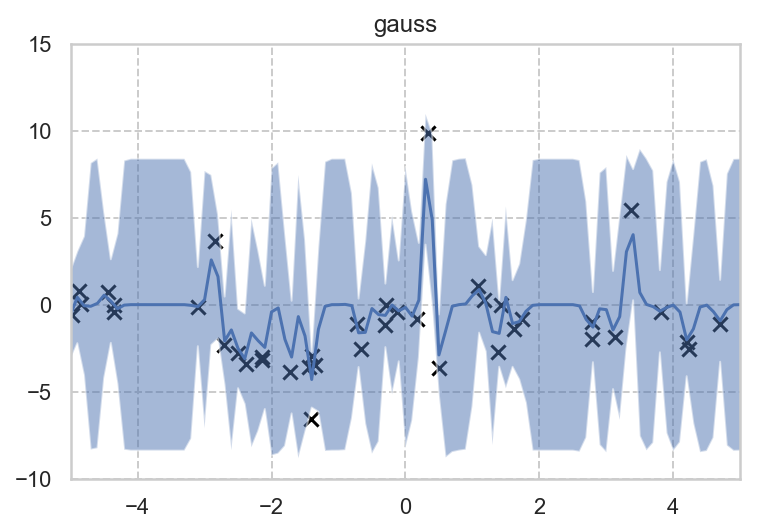

In [142]:
#グラフ化
plt.figure()
plt.xlim(-5,5)
plt.ylim(-10.0,15.0)
plt.title('gauss')

#学習データ
plt.scatter(x.T.tolist()[0], y.T.tolist()[0], s=50, c='black',marker='x')

#予測値(期待値)
plt.plot(x_test.T.tolist()[0], mu)
plt.fill_between(x_test.T.tolist()[0], mu-var, mu+var, facecolor='b',alpha=0.5)

## ロジスティック関数

In [148]:
def logistic(x):
    return (1+math.e**-x)**-1

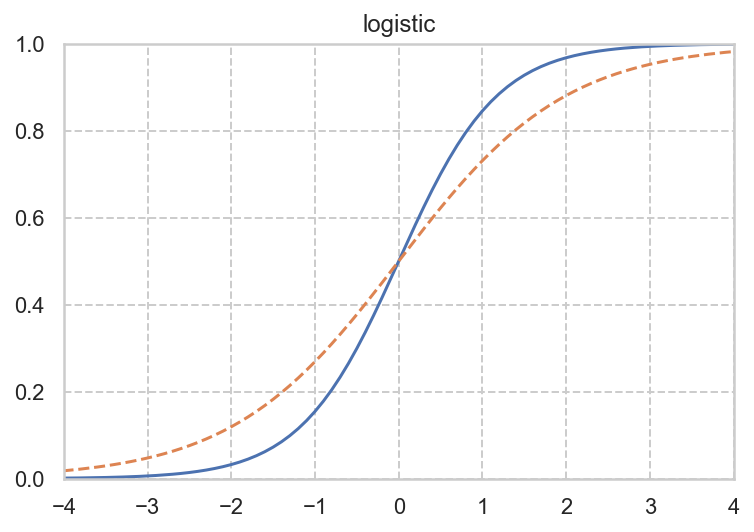

In [152]:
x_test = (np.arange(-10, 10, 0.1)).tolist()
y_17l = [logistic(1.7*x_t) for x_t in x_test]
y_l = [logistic(x_t) for x_t in x_test]

#グラフ化
plt.figure()
plt.xlim(-4,4)
plt.ylim(0,1)
plt.title('logistic')

#学習データ
plt.plot(x_test, y_17l)
plt.plot(x_test, y_l, "--")

# ポアソン分布

In [153]:
def poisson(y, lam):
    return lam**y*math.e**(-1*lam)/math.factorial(y)

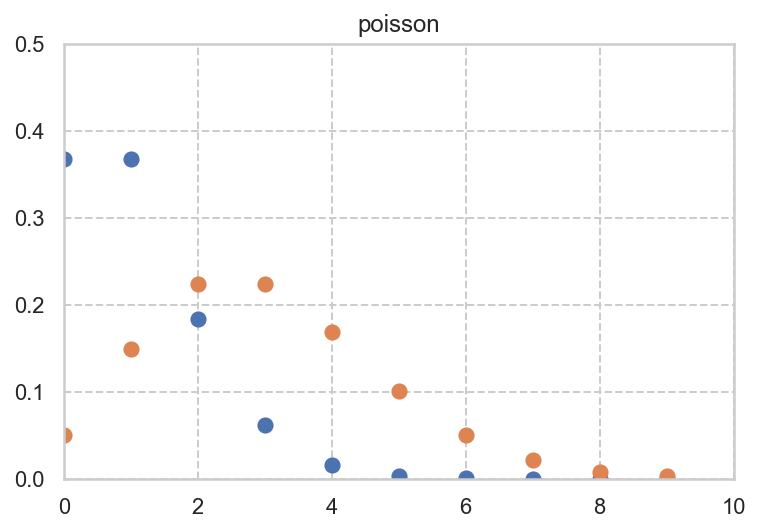

In [158]:
x_test = (np.arange(0, 10, 1)).tolist()
y_1p = [poisson(x_t, 1) for x_t in x_test]
y_3p = [poisson(x_t, 3) for x_t in x_test]


#グラフ化
plt.figure()
plt.xlim(0,10)
plt.ylim(0,0.5)
plt.title('poisson')

#学習データ
plt.scatter(x_test, y_1p, s=50, marker='o')
plt.scatter(x_test, y_3p, s=50, marker='o')